In [33]:
import pickle
from joblib import Parallel, delayed

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm



import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2


In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download()

In [9]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# nltk.download('wordnet')
# nltk.download("averaged_perceptron_tagger")
# nltk.download("punkt")
# nltk.download("stopwords")

In [7]:
with open("tech_remarks_VerbNoun_Phrases.pickle", "rb") as f:
    tech_vn_phrases = pickle.load(f)

In [10]:
# get data
df = pd.read_parquet("data/cbk_techremark_and_kg")
df_ukc_eng = df[df["KG"].isin(["UKC"])].reset_index(drop = True).dropna()

df_ukc_eng.head()



JOB_TECHREMARK SCSA SCSAG SCSB SCSBG  \
0  Lift stop/starting when travelling. New SMIC r...    1     T   12    91   
1                                              reset    6     E   39    30   
2           door belt brocken again,fitted new,brac»    1     T   89    80   
3           Lift out of order at ground floor level»    1     T   81    80   
4  Fire grounding checking ok, Fault rectified at...    2     T   50    50   

  SCSC   KG  
0    5  UKC  
1    9  UKC  
2    4  UKC  
3    6  UKC  
4    7  UKC

In [6]:
df_ukc_eng.shape

(122157, 7)

In [11]:
text_tech_remarks_eng = df_ukc_eng.JOB_TECHREMARK.tolist()

In [12]:
text_tech_remarks_eng[100:110]

['Inspection visit. AMC REPROGRAMMED monitoring. Confirmed all ok.',
 'Jhtis tripped JHTIS tripped. Checked over flexes as best, seems ok. Suspect SDIC print part on order. On stop',
 'Required new contact. Will obtain in am to complete. Lis Replaced lock contacts and set up door on 4th floor',
 '10 Hopetoun, Found lift isolated. Techn»',
 'Adjusted car guide shoes',
 'W. O. A. Checked, adjusted car door to suit and monitored without fault. R. T. S.',
 'Hard pressure needed replacement button needed Hard pressure needed replacement button needed',
 'Attended site to check lift alarm checked phoneline ok checked wiring connections found loose connections on car top ETMA unit Repaired and tested to NCC all ok LIS',
 'Roa, no recent faults on error log. Ran and tested unable to repeat any faults. LIS, RH lift ooo for repairs.',
 'found lift stuck on 3rd floor sweet wrapper between landing and car doors, removed, ran and function tested lift no faults after left lift in working order']

In [13]:
from utils.utils import GetVerbsNouns

tech_remarks_VN_Phrases = GetVerbsNouns(text_tech_remarks_eng, 4)

In [14]:
tech_remarks_VerbNoun_Phrases = tech_remarks_VN_Phrases.generate_VerbNounPhrases()

tokenizing:   0%|          | 0/122157 [00:00<?, ?it/s]

pos-tagging:   0%|          | 0/122157 [00:00<?, ?it/s]

getting-VerbNoun-Phrases:   0%|          | 0/122157 [00:00<?, ?it/s]

In [28]:
tech_remarks_VN = [" ".join(i) for i in tech_remarks_VerbNoun_Phrases]


In [21]:
# from pattern.en import parse
# from pattern.en import pprint

# pprint(parse('This cat was chased by a dog', relations=True, lemmata=True))

In [42]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union({"need","needn't","needn","might","couldn","couldn't","could","mightn't","lift"})

def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word)

In [43]:
def preprocess(sent):
    
    tokens = nltk.word_tokenize(sent.lower())
    tokens = [t for t in tokens if t not in stop_words and len(t) > 3]
    tokens = [get_lemma(t) for t in tokens]
    
    return tokens
  

tech_remarks_normalized = Parallel(n_jobs=4)(
    delayed(preprocess)(sent) for sent in tqdm(tech_remarks_VN, desc="tokenizing")
)

tokenizing:   0%|          | 0/122157 [00:00<?, ?it/s]

In [45]:


dictionary = corpora.Dictionary(tech_remarks_normalized)

dictionary.filter_extremes(no_below = 15, no_above = 0.25)

In [46]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 7:
        break

0 light
1 require
2 smic
3 stop
4 supply
5 travel
6 reset
7 belt


In [47]:
corpus = [dictionary.doc2bow(text) for text in tech_remarks_normalized]


In [49]:
# def find_coherence(n, corpus=corpus, texts=tech_remarks_VerbNoun_Phrases, dictionary=dictionary):
#     lda = gensim.models.LdaModel(corpus, num_topics = n)
#     cm = CoherenceModel(model = lda, texts = texts, dictionary = dictionary, coherence = 'c_v')
#     #coherence_scores.append(round(cm.get_coherence(), 5))
#     #print(round(cm.get_coherence(), 5))
#     out = round(cm.get_coherence(), 5)
#     return out
    

# coherence_scores_lda = Parallel(n_jobs=4)(
#         delayed(find_coherence)(n) for n in tqdm(range(5,10,2), desc="LDA")
#     )

In [54]:
"""
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. 
These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
"""

num_topics = list(range(5,22,2))
coherence_scores = []
for n in tqdm(num_topics):
    lda = gensim.models.LdaModel(corpus, num_topics = n)

    cm = CoherenceModel(model = lda, texts = tech_remarks_normalized, dictionary = dictionary, coherence = 'c_v')

    coherence_scores.append(round(cm.get_coherence(), 5))


  0%|          | 0/9 [00:00<?, ?it/s]

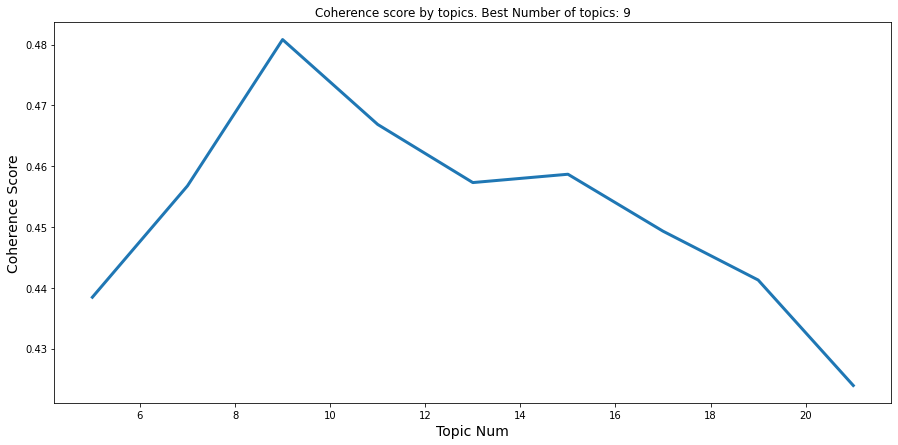

In [55]:
# get number of topics with the highest coherence scores
scores = list(zip(num_topics, coherence_scores))
best_num_topics = sorted(scores, key = lambda x: x[1], reverse = True)[0][0]

fig = plt.figure(figsize = (15,7))
plt.plot(num_topics, coherence_scores, linewidth = 3)
plt.xlabel("Topic Num", fontsize = 14)
plt.ylabel("Coherence Score", fontsize = 14)
plt.title(f"Coherence score by topics. Best Number of topics: {best_num_topics}")
plt.show()


In [56]:
# 8 topics:

lda_model = gensim.models.LdaModel(corpus, num_topics = 9, id2word = dictionary)


In [57]:
for idx, topic in lda_model.print_topics(-1):
    print("Words: {} \nTopics: {}".format(topic, idx))
    print("\n")

Words: 0.122*"floor" + 0.101*"lock" + 0.100*"adjust" + 0.059*"land" + 0.037*"test" + 0.030*"contact" + 0.030*"ground" + 0.029*"skate" + 0.023*"roller" + 0.020*"left" 
Topics: 0


Words: 0.086*"repair" + 0.056*"floor" + 0.048*"edge" + 0.045*"button" + 0.041*"push" + 0.040*"land" + 0.034*"require" + 0.029*"safety" + 0.024*"damage" + 0.021*"jammed" 
Topics: 1


Words: 0.115*"light" + 0.074*"replace" + 0.058*"switch" + 0.046*"require" + 0.028*"tube" + 0.028*"brake" + 0.027*"tech" + 0.022*"faulty" + 0.020*"print" + 0.018*"lead" 
Topics: 2


Words: 0.141*"checked" + 0.116*"reset" + 0.041*"safety" + 0.041*"power" + 0.035*"operation" + 0.032*"switch" + 0.031*"control" + 0.030*"circuit" + 0.026*"tripped" + 0.022*"fault" 
Topics: 3


Words: 0.127*"work" + 0.088*"order" + 0.062*"belt" + 0.058*"alarm" + 0.041*"test" + 0.037*"fire" + 0.028*"drive" + 0.025*"left" + 0.024*"require" + 0.022*"replace" 
Topics: 4


Words: 0.078*"release" + 0.075*"trap" + 0.060*"arrival" + 0.060*"found" + 0.047*"passenge

In [46]:
from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

In [58]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [59]:
p = gensimvis.prepare(lda_model, corpus, dictionary)
# pyLDAvis.save_html(p, "PyLDAvis_overview.html")


/home/matoshiv/python/python_envs/nlp_venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [60]:
pyLDAvis.save_html(p, "top_9_topics_VerbNounePhrases.html")
